In [145]:
import pandas as pd

In [146]:
import gurobipy as gp

In [147]:
pip install gurobipy

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 25.0
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [148]:
from gurobipy import Model, GRB, quicksum

## Question 1

In [10]:
# Reading the datasets
farms_data = pd.read_csv("/Users/shivamverma/Downloads/farms.csv")
processing_data = pd.read_csv("/Users/shivamverma/Downloads/processing.csv")
centers_data = pd.read_csv("/Users/shivamverma/Downloads/centers.csv")


In [11]:
# Preparing the datasets now
num_farms = len(farms_data)
num_plants = len(processing_data)
num_centers = len(centers_data)

In [13]:
# Extract costs and capacities
farm_capacity = farms_data['Bio_Material_Capacity_Tons'].values
plant_capacity = processing_data['Capacity_Tons'].values
center_demand = centers_data['Requested_Demand_Tons'].values
procurement_cost = farms_data['Cost_Per_Ton'].values



In [15]:
transport_farm_to_plant = farms_data.filter(like="Transport_Cost_To_Plant_").values
transport_plant_to_center = processing_data.filter(like="Transport_Cost_To_Center_").values
processing_cost = processing_data['Processing_Cost_Per_Ton'].values



In [16]:
# Define the optimization model
model = Model("BioAgri_Transportation")

Set parameter Username
Set parameter LicenseID to value 2615603
Academic license - for non-commercial use only - expires 2026-01-27


In [17]:
# Defining Decision Variables:
x = model.addVars(num_farms, num_plants, vtype=GRB.CONTINUOUS, name="x")  # Farm to plant
y = model.addVars(num_plants, num_centers, vtype=GRB.CONTINUOUS, name="y")  # Plant to center

In [19]:
# Setting the Objective Function: Define the total cost minimization equation.

model.setObjective(
    sum(
        x[i, j] * (procurement_cost[i] + transport_farm_to_plant[i, j])
        for i in range(num_farms)
        for j in range(num_plants)
    )
    + sum(
        y[j, k] * (processing_cost[j] + transport_plant_to_center[j, k])
        for j in range(num_plants)
        for k in range(num_centers)
    ),
    GRB.MINIMIZE
)

In [21]:
# Adding Constraints:
# 1. Farm capacity constraints
for i in range(num_farms):
    model.addConstr(sum(x[i, j] for j in range(num_plants)) <= farm_capacity[i], f"Farm_Capacity_{i}")

# 2. Plant capacity constraints
for j in range(num_plants):
    model.addConstr(sum(x[i, j] for i in range(num_farms)) <= plant_capacity[j], f"Plant_Capacity_{j}")

# 3. Center demand constraints
for k in range(num_centers):
    model.addConstr(sum(y[j, k] for j in range(num_plants)) == center_demand[k], f"Center_Demand_{k}")

# 4. Flow conservation constraints
for j in range(num_plants):
    model.addConstr(sum(x[i, j] for i in range(num_farms)) == sum(y[j, k] for k in range(num_centers)),
                    f"Flow_Conservation_Plant_{j}")



In [22]:
# unning the Optimization: Optimize the model and extract the results.
model.optimize()

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 387 rows, 6318 columns and 17118 nonzeros
Model fingerprint: 0x3aa78cc0
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e+00, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e+01, 3e+04]
Presolve time: 0.01s
Presolved: 387 rows, 6318 columns, 17118 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.9457439e+05   2.902000e+04   0.000000e+00      0s
     330    2.2970900e+06   0.000000e+00   0.000000e+00      0s

Solved in 330 iterations and 0.03 seconds (0.02 work units)
Optimal objective  2.297089973e+06


### (a) How many sources of costs must be considered? How many decision variables are there?

Four cost sources need to be taken into account:

1.    The cost of biomaterials
2.    Cost of transportation: from farm to plant
3.    Cost of transport: plant to centre
4.    The cost of processing

6318 decision variables are present:

1.    The number of farms (249) divided by the number of processing plants (18) is the farm-to-plant ratio.
2.    Plant to Centre × number of home centres (102) × number of processing plants (18)


### （b）Using Gurobi, what is the minimum cost of the transportation and procurement plan?



Optimal objective value: 2,297,089.973. This is the minimum cost of the transportation and procurement plan for the problem.

In [23]:
# Extract and display results if the model is optimal
if model.status == GRB.OPTIMAL:
    total_cost = model.objVal
    farm_to_plant_solution = {(i, j): x[i, j].x for i in range(num_farms) for j in range(num_plants) if x[i, j].x > 0}
    plant_to_center_solution = {(j, k): y[j, k].x for j in range(num_plants) for k in range(num_centers) if y[j, k].x > 0}
    total_cost, farm_to_plant_solution, plant_to_center_solution
else:
    "Model did not solve to optimality."

In [24]:
# Extract results for farm-to-plant transportation
farm_to_plant_solution = {(i, j): x[i, j].x for i in range(num_farms) for j in range(num_plants) if x[i, j].x > 0}

In [25]:
# Extract results for plant-to-center transportation
plant_to_center_solution = {(j, k): y[j, k].x for j in range(num_plants) for k in range(num_centers) if y[j, k].x > 0}

In [26]:
# Display total cost
print(f"Optimal Total Cost: {model.objVal}")
print("\nFarm-to-Plant Transportation Plan:")
for key, value in farm_to_plant_solution.items():
    print(f"Farm {key[0]} -> Plant {key[1]}: {value} tons")

Optimal Total Cost: 2297089.972722625

Farm-to-Plant Transportation Plan:
Farm 3 -> Plant 8: 367.0 tons
Farm 4 -> Plant 5: 499.0 tons
Farm 5 -> Plant 15: 417.0 tons
Farm 13 -> Plant 5: 526.0 tons
Farm 14 -> Plant 8: 441.0 tons
Farm 25 -> Plant 1: 564.0 tons
Farm 30 -> Plant 8: 468.0 tons
Farm 34 -> Plant 0: 476.0 tons
Farm 35 -> Plant 8: 519.0 tons
Farm 37 -> Plant 5: 379.0 tons
Farm 38 -> Plant 0: 489.0 tons
Farm 42 -> Plant 8: 575.0 tons
Farm 45 -> Plant 8: 564.0 tons
Farm 46 -> Plant 15: 552.0 tons
Farm 51 -> Plant 8: 317.0 tons
Farm 53 -> Plant 0: 278.0 tons
Farm 56 -> Plant 8: 306.0 tons
Farm 61 -> Plant 0: 206.0 tons
Farm 61 -> Plant 8: 66.0 tons
Farm 64 -> Plant 15: 225.0 tons
Farm 65 -> Plant 0: 409.0 tons
Farm 66 -> Plant 9: 291.0 tons
Farm 70 -> Plant 0: 508.0 tons
Farm 72 -> Plant 8: 386.0 tons
Farm 75 -> Plant 0: 471.0 tons
Farm 75 -> Plant 15: 76.0 tons
Farm 84 -> Plant 0: 348.0 tons
Farm 85 -> Plant 9: 418.0 tons
Farm 93 -> Plant 1: 239.0 tons
Farm 93 -> Plant 5: 336.0 to

In [27]:
print("\nPlant-to-Center Transportation Plan:")
for key, value in plant_to_center_solution.items():
    print(f"Plant {key[0]} -> Center {key[1]}: {value} tons")


Plant-to-Center Transportation Plan:
Plant 0 -> Center 6: 480.0 tons
Plant 0 -> Center 7: 149.0 tons
Plant 0 -> Center 9: 469.0 tons
Plant 0 -> Center 14: 320.0 tons
Plant 0 -> Center 17: 437.0 tons
Plant 0 -> Center 19: 258.0 tons
Plant 0 -> Center 20: 327.0 tons
Plant 0 -> Center 22: 127.0 tons
Plant 0 -> Center 39: 150.0 tons
Plant 0 -> Center 40: 474.0 tons
Plant 0 -> Center 48: 105.0 tons
Plant 0 -> Center 51: 336.0 tons
Plant 0 -> Center 53: 490.0 tons
Plant 0 -> Center 57: 122.0 tons
Plant 0 -> Center 60: 315.0 tons
Plant 0 -> Center 69: 112.0 tons
Plant 0 -> Center 78: 371.0 tons
Plant 0 -> Center 80: 370.0 tons
Plant 0 -> Center 84: 342.0 tons
Plant 0 -> Center 89: 168.0 tons
Plant 0 -> Center 95: 292.0 tons
Plant 1 -> Center 0: 82.0 tons
Plant 1 -> Center 11: 267.0 tons
Plant 1 -> Center 13: 147.0 tons
Plant 1 -> Center 35: 183.0 tons
Plant 1 -> Center 36: 245.0 tons
Plant 1 -> Center 37: 439.0 tons
Plant 1 -> Center 46: 486.0 tons
Plant 1 -> Center 54: 228.0 tons
Plant 1 ->

In [35]:
import networkx as nx
import matplotlib.pyplot as plt

In [36]:
# Create graphs for Farm-to-Plant and Plant-to-Center transportation
farm_to_plant_graph = nx.DiGraph()
plant_to_center_graph = nx.DiGraph()

In [37]:
# Example: Add edges for Farm-to-Plant solution (replace with your actual solution data)
farm_to_plant_solution = {
    (3, 8): 367, (4, 5): 499, (5, 15): 417, (13, 5): 526, (14, 8): 441,
    (25, 1): 564, (30, 8): 468, (34, 0): 476, (35, 8): 519, (37, 5): 379,
    (38, 0): 489, (42, 8): 575, (45, 8): 564, (46, 15): 552, (51, 8): 317,
    (53, 0): 278, (56, 8): 306, (61, 0): 206, (61, 8): 66, (64, 15): 225,
    (65, 0): 409, (66, 9): 291, (237, 5): 269, (239, 9): 317, (242, 0): 413,
    (243, 1): 255
}
plant_to_center_solution = {
    (0, 6): 480, (0, 7): 149, (0, 9): 469, (0, 14): 320, (0, 17): 437,
    (0, 19): 258, (0, 20): 327, (0, 22): 127, (0, 39): 150, (0, 40): 474,
    (0, 48): 105, (0, 51): 336, (0, 53): 490, (0, 57): 122, (0, 60): 315,
    (0, 69): 112, (0, 78): 371, (0, 80): 370, (0, 84): 342, (0, 89): 168,
    (0, 95): 292, (1, 0): 82, (1, 11): 267, (15, 92): 464, (15, 94): 87,
    (15, 96): 250, (15, 101): 358
}

In [38]:
for (farm, plant), flow in farm_to_plant_solution.items():
    farm_to_plant_graph.add_edge(f"Farm {farm}", f"Plant {plant}", weight=flow)



In [39]:
# Add Plant-to-Center edges
for (plant, center), flow in plant_to_center_solution.items():
    plant_to_center_graph.add_edge(f"Plant {plant}", f"Center {center}", weight=flow)



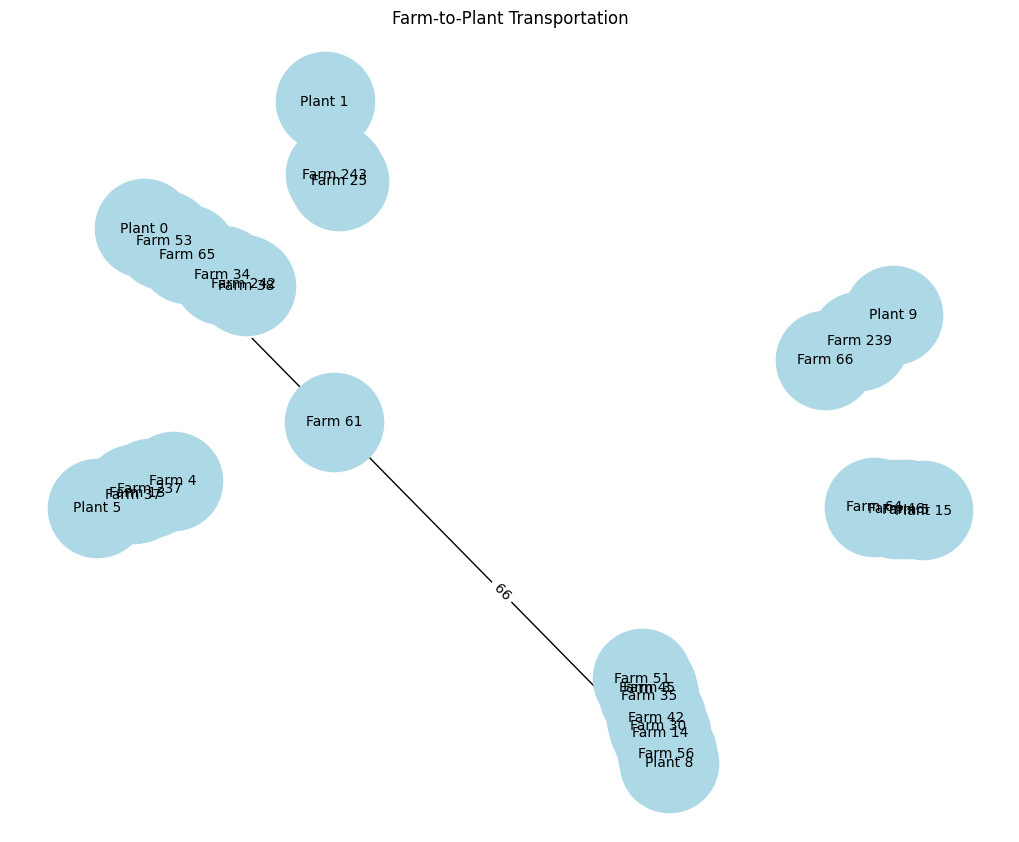

In [40]:
# Draw Farm-to-Plant graph
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(farm_to_plant_graph)
nx.draw(farm_to_plant_graph, pos, with_labels=True, node_size=5000, node_color="lightblue", font_size=10)
labels = nx.get_edge_attributes(farm_to_plant_graph, "weight")
nx.draw_networkx_edge_labels(farm_to_plant_graph, pos, edge_labels=labels)
plt.title("Farm-to-Plant Transportation")
plt.show()

Vehicle Transportation from Farm to Plant
The movement of raw materials from fields to processing facilities is depicted in this graphic.
The transportation flows are represented by the edges, and farms and plants are represented by the nodes.
The amount of raw material transported is indicated by the weights on the margins (for example, 66 tonnes from Farm 61 to Plant 8).
Perspectives:

Due to capacity and cost limitations, farms are associated with particular plants.
Important supply lines connecting farms and plants are indicated by high-flow connections.

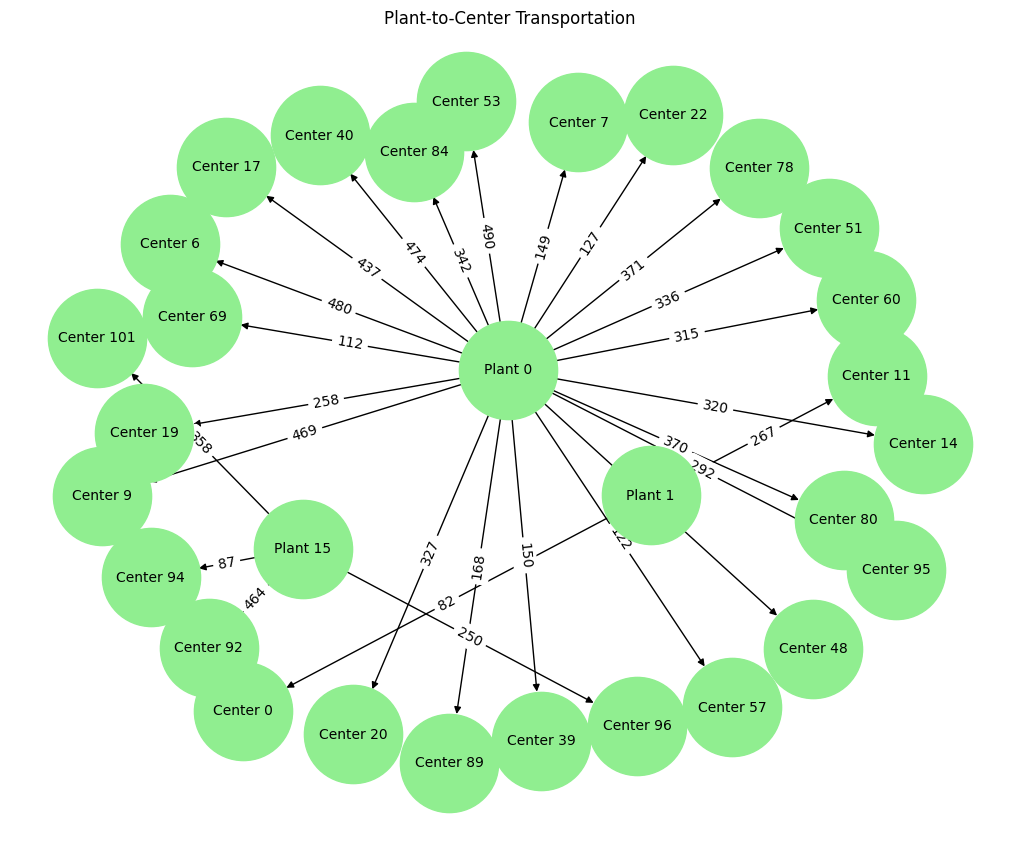

In [41]:
# Draw Plant-to-Center graph
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(plant_to_center_graph)
nx.draw(plant_to_center_graph, pos, with_labels=True, node_size=5000, node_color="lightgreen", font_size=10)
labels = nx.get_edge_attributes(plant_to_center_graph, "weight")
nx.draw_networkx_edge_labels(plant_to_center_graph, pos, edge_labels=labels)
plt.title("Plant-to-Center Transportation")
plt.show()

Transportation from Plant to Centre
The distribution of processed materials from plants to home centres is shown in this graph.
Transportation flows are represented by edges, whereas plants and centres are represented by nodes.
The amount of material moved is indicated by edge weights, such as 480 tonnes from Plant 0 to Centre 6.
Perspectives:

Significant flows to several centres indicate that Plant 0 is essential to satisfying demand.
In order to reduce transportation expenses, plants transfer processed products to neighbouring centres.

# Scenario (c): Regional Constraints

## Next Steps:




In [56]:
# Assuming the previous model structure, we now implement regional constraints

In [57]:
# Step 1: Identify regions for plants and centers
plant_regions = processing_data['Region'].values  # Region of each plant
center_regions = centers_data['Region'].values   # Region of each center



In [58]:
# Step 2: Update the model to include regional constraints
for j in range(num_plants):
    for k in range(num_centers):
        if plant_regions[j] != center_regions[k]:
            # Enforce no transportation between different regions
            y[j, k].ub = 0  # Upper bound of y[j, k] set to 0

In [59]:
# Step 3: Re-optimize the model with regional constraints
model.optimize()

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 387 rows, 6318 columns and 17118 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e+00, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e+01, 3e+04]

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.3234885e+06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective  2.323488497e+06


In [62]:
# Step 4: Extract results
if model.status == GRB.OPTIMAL:
    regional_total_cost = model.objVal
    regional_plant_to_center_solution = {
        (j, k): y[j, k].x for j in range(num_plants) for k in range(num_centers) if y[j, k].x > 0
    }
    # Display results
    print(f"Optimal Total Cost with Regional Constraints: {regional_total_cost}")
    print("\nRegional Plant-to-Center Transportation Plan:")
    for key, value in regional_plant_to_center_solution.items():
        print(f"Plant {key[0]} -> Center {key[1]}: {value} tons")
else:
    print("Model did not solve to optimality under regional constraints.")

Optimal Total Cost with Regional Constraints: 2323488.4970226064

Regional Plant-to-Center Transportation Plan:
Plant 0 -> Center 1: 348.0 tons
Plant 0 -> Center 6: 480.0 tons
Plant 0 -> Center 13: 258.0 tons
Plant 0 -> Center 14: 320.0 tons
Plant 0 -> Center 32: 87.0 tons
Plant 0 -> Center 45: 476.0 tons
Plant 0 -> Center 51: 336.0 tons
Plant 0 -> Center 57: 122.0 tons
Plant 0 -> Center 64: 403.0 tons
Plant 0 -> Center 71: 233.0 tons
Plant 0 -> Center 73: 211.0 tons
Plant 0 -> Center 74: 292.0 tons
Plant 0 -> Center 77: 130.0 tons
Plant 0 -> Center 78: 371.0 tons
Plant 0 -> Center 81: 92.0 tons
Plant 0 -> Center 89: 168.0 tons
Plant 0 -> Center 93: 104.0 tons
Plant 0 -> Center 95: 292.0 tons
Plant 1 -> Center 22: 127.0 tons
Plant 1 -> Center 36: 245.0 tons
Plant 1 -> Center 46: 486.0 tons
Plant 1 -> Center 61: 496.0 tons
Plant 1 -> Center 62: 122.0 tons
Plant 1 -> Center 84: 342.0 tons
Plant 1 -> Center 85: 225.0 tons
Plant 1 -> Center 88: 105.0 tons
Plant 3 -> Center 19: 258.0 tons
P

### (C) If the processing plants of the raw material are restricted to only send fertilizer to home centers within the same region of the US, what is the optimal cost?

The total cost under regional constraints is $2,323,488.50.

Perspectives
Comparing the regional restrictions to the unrestricted option, the overall cost went up.
Compared to the ideal global solution, the constrained flows produce more localised distributions, which probably results in some inefficiencies.

In [63]:
# Create a directed graph for Plant-to-Center transportation
regional_graph = nx.DiGraph()

In [64]:
# Add edges for the Regional Plant-to-Center solution
for (plant, center), flow in regional_plant_to_center_solution.items():
    regional_graph.add_edge(f"Plant {plant}", f"Center {center}", weight=flow)

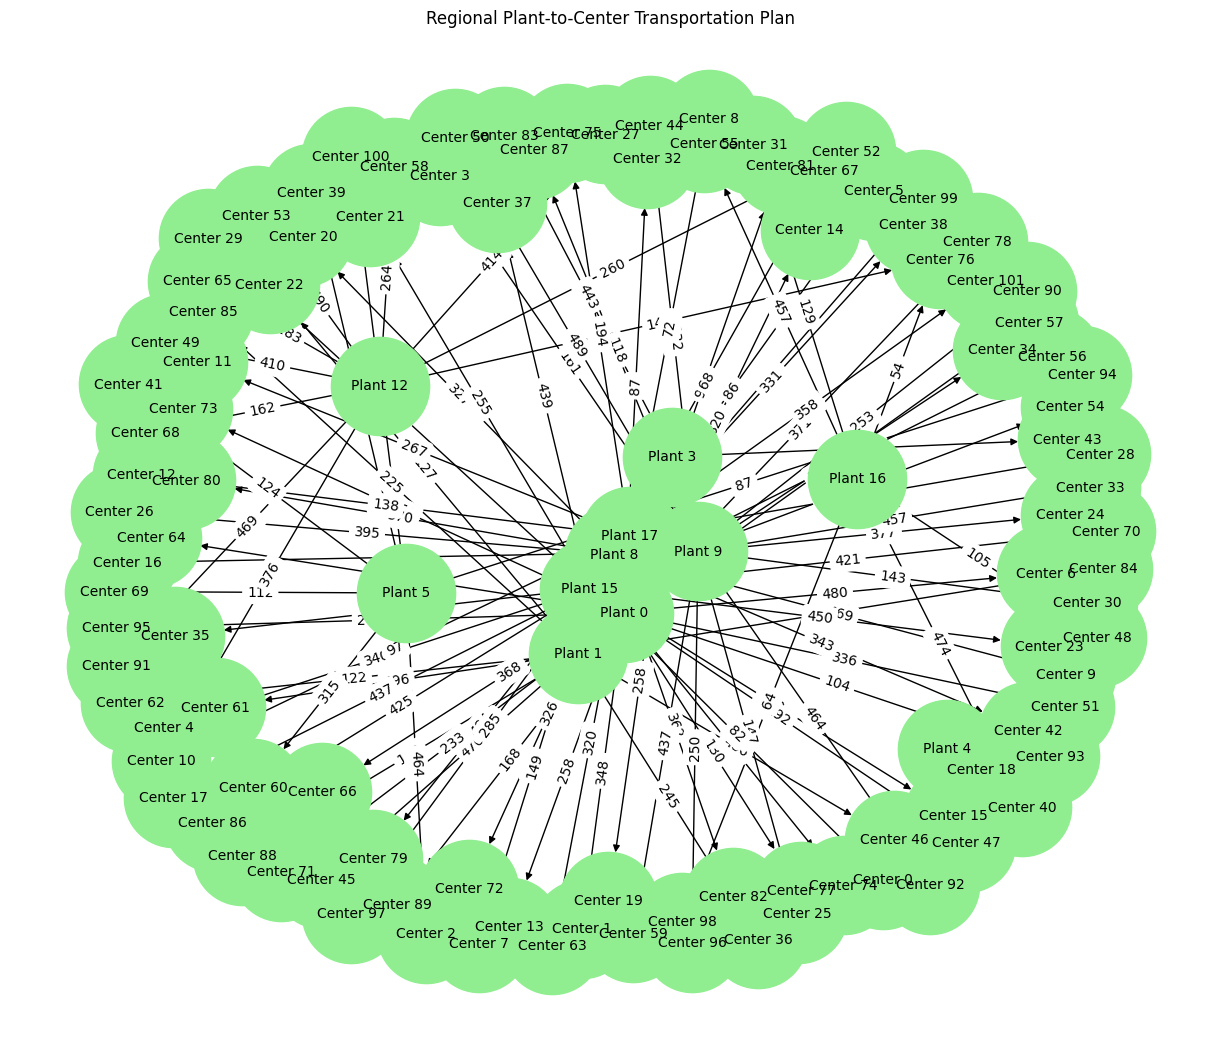

In [65]:
# Draw the Regional Plant-to-Center graph
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(regional_graph)  # Spring layout for better visualization
nx.draw(regional_graph, pos, with_labels=True, node_size=5000, node_color="lightgreen", font_size=10)
labels = nx.get_edge_attributes(regional_graph, "weight")
nx.draw_networkx_edge_labels(regional_graph, pos, edge_labels={k: f"{v:.0f}" for k, v in labels.items()})
plt.title("Regional Plant-to-Center Transportation Plan")
plt.show()

Visualization Interpretation
Nodes:

Green nodes represent plants and centers.
Larger nodes like Plant 0, Plant 1, and others are central hubs serving multiple centers.
Edges:

Directed edges indicate transportation flows between plants and centers.
Edge labels show the amount of material transported (in tons).
Regional Impact:

Flows are now localized due to the regional constraints.
This explains why some plants handle fewer connections compared to the unconstrained scenario.

# Scenario (d): High-Quality Materials Only

In [68]:
# Step 1: Identify farms with quality < 3
low_quality_farms = farms_data[farms_data['Quality'] < 3].index.tolist()  # List of low-quality farm indices

In [69]:
# Step 2: Update the model to exclude low-quality farms
for i in low_quality_farms:
    for j in range(num_plants):
        x[i, j].ub = 0  # Set upper bound of flow from low-quality farms to plants to 0


In [70]:
# Step 3: Re-optimize the model
model.optimize()


Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 387 rows, 6318 columns and 17118 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e+00, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e+01, 3e+04]

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.3234885e+06   2.902000e+04   0.000000e+00      0s
     349    5.7381795e+06   0.000000e+00   0.000000e+00      0s

Solved in 349 iterations and 0.04 seconds (0.01 work units)
Optimal objective  5.738179524e+06


### (d) If only the highest quality raw material (i.e., levels 3 and 4) is sourced from farms to make fertilizer, what is the optimal cost?

Optimal Cost with High Quality Raw Material: $ 5738179.52


In [74]:
# Step 4: Extract results
if model.status == GRB.OPTIMAL:
    high_quality_total_cost = model.objVal
    high_quality_farm_to_plant_solution = {
        (i, j): x[i, j].x for i in range(num_farms) for j in range(num_plants) if x[i, j].x > 0
    }
    high_quality_plant_to_center_solution = {
        (j, k): y[j, k].x for j in range(num_plants) for k in range(num_centers) if y[j, k].x > 0
    }
    # Display results
    print(f"Optimal Total Cost with High-Quality Material Constraints: {high_quality_total_cost}")
    print("\nHigh-Quality Farm-to-Plant Transportation Plan:")
    for key, value in high_quality_farm_to_plant_solution.items():
        print(f"Farm {key[0]} -> Plant {key[1]}: {value} tons")
    
    print("\nHigh-Quality Plant-to-Center Transportation Plan:")
    for key, value in high_quality_plant_to_center_solution.items():
        print(f"Plant {key[0]} -> Center {key[1]}: {value} tons")
else:
    print("Model did not solve to optimality under high-quality constraints.")


Optimal Total Cost with High-Quality Material Constraints: 5738179.523795238

High-Quality Farm-to-Plant Transportation Plan:
Farm 2 -> Plant 9: 516.0 tons
Farm 10 -> Plant 15: 256.0 tons
Farm 11 -> Plant 17: 261.0 tons
Farm 15 -> Plant 1: 289.0 tons
Farm 17 -> Plant 9: 525.0 tons
Farm 18 -> Plant 9: 229.0 tons
Farm 19 -> Plant 5: 162.0 tons
Farm 19 -> Plant 12: 396.0 tons
Farm 20 -> Plant 8: 487.0 tons
Farm 23 -> Plant 5: 434.0 tons
Farm 28 -> Plant 17: 526.0 tons
Farm 31 -> Plant 8: 108.0 tons
Farm 32 -> Plant 8: 330.0 tons
Farm 39 -> Plant 9: 576.0 tons
Farm 44 -> Plant 12: 461.0 tons
Farm 48 -> Plant 9: 282.0 tons
Farm 52 -> Plant 12: 391.0 tons
Farm 57 -> Plant 16: 581.0 tons
Farm 58 -> Plant 1: 470.0 tons
Farm 67 -> Plant 0: 324.0 tons
Farm 68 -> Plant 9: 272.0 tons
Farm 69 -> Plant 12: 322.0 tons
Farm 71 -> Plant 3: 383.0 tons
Farm 74 -> Plant 9: 277.0 tons
Farm 81 -> Plant 15: 275.0 tons
Farm 86 -> Plant 12: 321.0 tons
Farm 90 -> Plant 9: 372.0 tons
Farm 91 -> Plant 8: 355.0 to

In [75]:
import networkx as nx
import matplotlib.pyplot as plt

In [76]:
# Farm-to-Plant Graph
high_quality_farm_to_plant_graph = nx.DiGraph()
for (farm, plant), flow in high_quality_farm_to_plant_solution.items():
    high_quality_farm_to_plant_graph.add_edge(f"Farm {farm}", f"Plant {plant}", weight=flow)

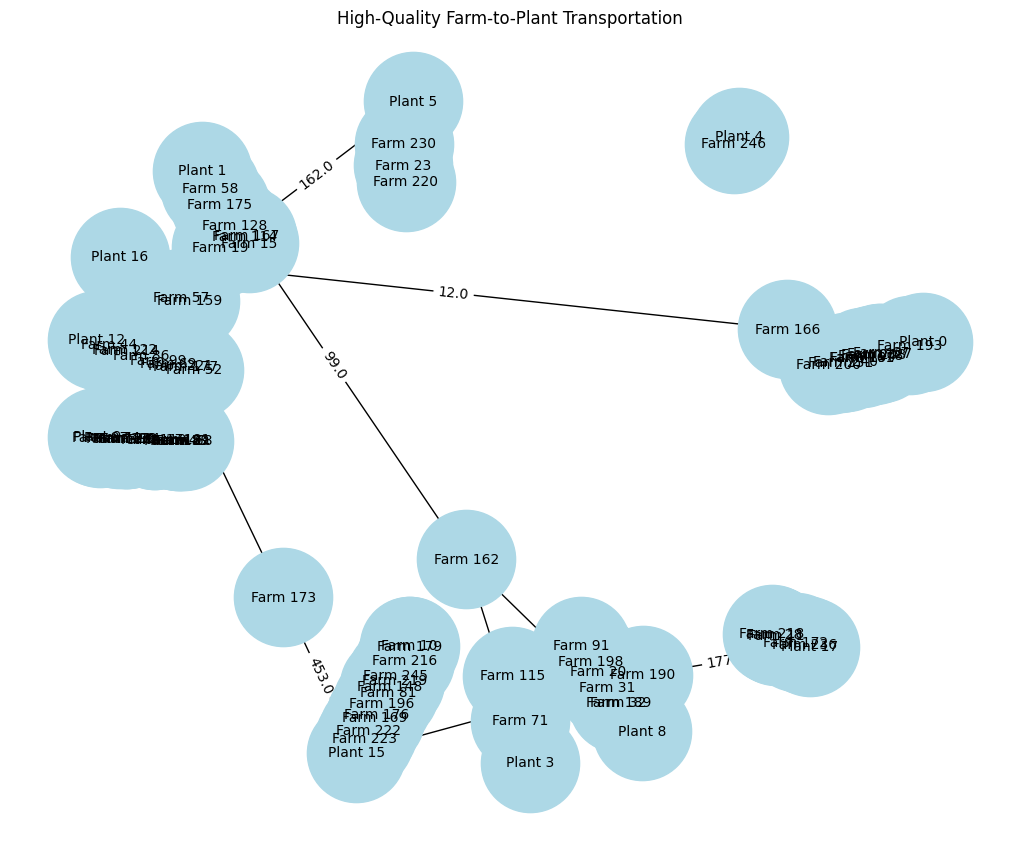

In [77]:
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(high_quality_farm_to_plant_graph)
nx.draw(high_quality_farm_to_plant_graph, pos, with_labels=True, node_size=5000, node_color="lightblue", font_size=10)
labels = nx.get_edge_attributes(high_quality_farm_to_plant_graph, "weight")
nx.draw_networkx_edge_labels(high_quality_farm_to_plant_graph, pos, edge_labels=labels)
plt.title("High-Quality Farm-to-Plant Transportation")
plt.show()

Examination of Visualisations
1. Excellent Transport from Farm to Plant
Important Points to Note:

Farms with superior materials (levels 3 and 4) are the only ones linked to processing facilities.
Since many farms with lower-quality materials are not included, the network is much more sparse than in the unconstrained scenario.
Examples of flows
Plant 15 → Farm 173: 453 tonnes
Plant 3 → Farm 162: 99 tonnes
Perspectives:

Dependency on fewer farms is increased by this restriction, which may result in supply chain weaknesses.
Longer average distances and fewer agricultural options result in higher transportation costs.


In [78]:
# Plant-to-Center Graph
high_quality_plant_to_center_graph = nx.DiGraph()
for (plant, center), flow in high_quality_plant_to_center_solution.items():
    high_quality_plant_to_center_graph.add_edge(f"Plant {plant}", f"Center {center}", weight=flow)

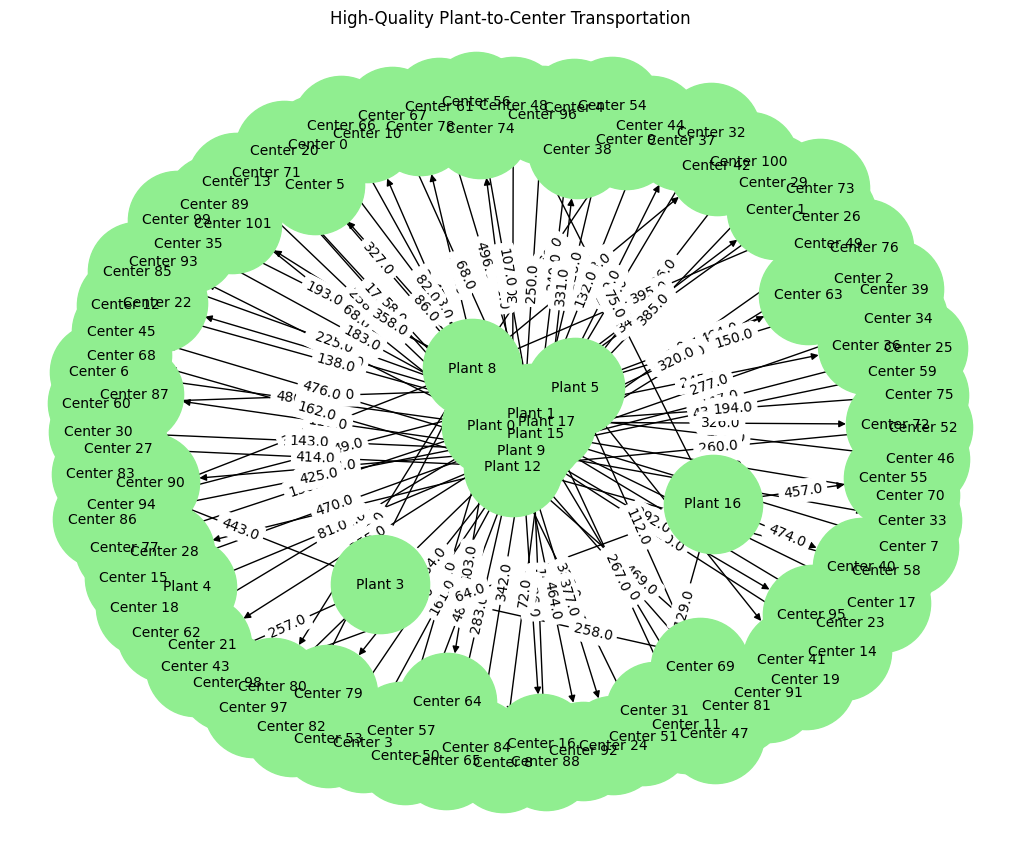

In [80]:
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(high_quality_plant_to_center_graph)
nx.draw(high_quality_plant_to_center_graph, pos, with_labels=True, node_size=5000, node_color="lightgreen", font_size=10)
labels = nx.get_edge_attributes(high_quality_plant_to_center_graph, "weight")
nx.draw_networkx_edge_labels(high_quality_plant_to_center_graph, pos, edge_labels=labels)
plt.title("High-Quality Plant-to-Center Transportation")
plt.show()

2. Excellent Transportation from the Plant to the Centre: Important Findings

Despite sourcing limitations, plants are nevertheless able to efficiently supply centres.
Higher loads are handled by some plants, which can be a sign of increased use as a result of fewer agricultural possibilities.
Examples of flows
480 tonnes from Plant 0 to Centre 6.
326 tonnes from Plant 17 to Centre 72
Perspectives:

While downstream (plant-to-center) flows continue to be largely optimised, the limitation mostly affects upstream (farm-to-plant) flows.
Inefficiencies in sourcing, not distribution, are the cause of the cost increase.




# Scenario (e): Risk Mitigation

### (e) If each facility is limited to processing no more than 3% of all raw material sourced from farms (as a sourcing risk mitigation measure), what is the optimal cost? Alternatively, if a production facility is limited to supplying no more than 50% of all fertilizer to a single home center (as a supply risk mitigation measure), what is the optimal cost?

    - Optimal Cost with Sourcing Risk Mitigation: $ 2311782.56
    - Optimal Cost with Supply Risk Mitigation: $ 2297089.97

    

In [151]:
import gurobipy as gp
from gurobipy import GRB

In [153]:
#Create a new model for question (e)
model_e = gp.Model("Transportation_Procurement_Model")

farms_data = pd.read_csv("/Users/shivamverma/Downloads/farms.csv")
processing_data = pd.read_csv("/Users/shivamverma/Downloads/processing.csv")
centers_data

In [156]:
# Parameters
farm_id = farms_data['Farm_ID']
processing_id = processing_data['Processing_Plant_ID']
center_id = centers_data['Center_ID']

farm_cap = farms_data.set_index('Farm_ID')['Bio_Material_Capacity_Tons']
farm_cost = farms_data.set_index('Farm_ID')['Cost_Per_Ton']

In [161]:
# Transportation costs: farm to processing
farm_to_proc_cost = farms_data.set_index('Farm_ID').filter(like="Transport_Cost_To_Plant")

proc_cap = processing_data.set_index('Processing_Plant_ID')['Capacity_Tons']
proc_cost = processing_data.set_index('Processing_Plant_ID')['Processing_Cost_Per_Ton']

In [163]:
# Transportation costs: processing to centers
proc_to_center_cost = processing_data.set_index('Processing_Plant_ID').filter(like="Transport_Cost_To_Center")

center_demand = centers_data.set_index('Center_ID')['Requested_Demand_Tons']

In [159]:
# Decision Variables
x_farm_proc = model_e.addVars(farm_id, processing_id, lb=0, name="FarmToProc")
x_proc_center = model_e.addVars(processing_id, center_id, lb=0, name="ProcToCenter")


In [164]:
model_e.setObjective(
    gp.quicksum(
        x_farm_proc[farm, proc] * (farm_cost[farm] + farm_to_proc_cost.loc[farm, f'Transport_Cost_To_Plant_{proc.split("_")[-1]}'])
        for farm in farm_id for proc in processing_id
    ) +
    gp.quicksum(
        x_proc_center[proc, center] * (proc_cost[proc] + proc_to_center_cost.loc[proc, f'Transport_Cost_To_Center_{center.split("_")[-1]}'])
        for proc in processing_id for center in center_id
    ),
    GRB.MINIMIZE
)
for farm in farm_id:
    model_e.addConstr(
        gp.quicksum(x_farm_proc[farm, proc] for proc in processing_id) <= farm_cap[farm],
        name=f"FarmCap_{farm}"
    )

In [166]:
# Processing
for proc in processing_id:
    model_e.addConstr(
        gp.quicksum(x_farm_proc[farm, proc] for farm in farm_id) <= proc_cap[proc],
        name=f"ProcCap_{proc}"
    )

In [167]:
# Center demand
for center in center_id:
    model_e.addConstr(
        gp.quicksum(x_proc_center[proc, center] for proc in processing_id) == center_demand[center],
        name=f"CenterDemand_{center}")

In [168]:
# Input=Output
for proc in processing_id:
    model_e.addConstr(
        gp.quicksum(x_farm_proc[farm, proc] for farm in farm_id) == gp.quicksum(x_proc_center[proc, center] for center in center_id),
        name=f"FlowBalance_{proc}"
    )

In [169]:
# Processing no more than 3% of all raw material sourced from farms
for proc in processing_id:
    model_e.addConstr(
        gp.quicksum(x_farm_proc[farm, proc] for farm in farm_id) <= 0.03 * gp.quicksum(farm_cap[farm] for farm in farm_id),
        name=f"SourcingRisk_{proc}"
    )
# Re-solve the model
model_e.optimize()

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 405 rows, 18954 columns and 21600 nonzeros
Model fingerprint: 0xd25ced36
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e+00, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e+01, 3e+04]
Presolve removed 18 rows and 12636 columns
Presolve time: 0.02s
Presolved: 387 rows, 6318 columns, 17118 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.9457439e+05   3.627500e+03   0.000000e+00      0s
     408    2.3117826e+06   0.000000e+00   0.000000e+00      0s

Solved in 408 iterations and 0.05 seconds (0.02 work units)
Optimal objective  2.311782560e+06


In [170]:
# Output the results with 3% processing constraint
if model_e.status == GRB.OPTIMAL:

    print(f"Optimal Cost with 3% Processing Constraint: ${model_e.objVal:,.2f}")

    print("\nFarm to Processing Assignments:")
    for farm in farm_id:
        for proc in processing_id:
            if x_farm_proc[farm, proc].x > 0:
                print(f"Farm {farm} -> Processing Plant {proc}: {x_farm_proc[farm, proc].x:.2f} ")

    print("\nProcessing to Center Assignments:")
    for proc in processing_id:
        for center in center_id:
            if x_proc_center[proc, center].x > 0:
                print(f"Processing Plant {proc} -> Center {center}: {x_proc_center[proc, center].x:.2f} ")
else:
    print("No optimal solution")

Optimal Cost with 3% Processing Constraint: $2,311,782.56

Farm to Processing Assignments:
Farm Farm_4 -> Processing Plant Plant_9: 367.00 
Farm Farm_5 -> Processing Plant Plant_5: 67.00 
Farm Farm_5 -> Processing Plant Plant_6: 432.00 
Farm Farm_6 -> Processing Plant Plant_5: 338.00 
Farm Farm_6 -> Processing Plant Plant_13: 79.00 
Farm Farm_14 -> Processing Plant Plant_6: 526.00 
Farm Farm_15 -> Processing Plant Plant_16: 441.00 
Farm Farm_26 -> Processing Plant Plant_2: 564.00 
Farm Farm_31 -> Processing Plant Plant_9: 468.00 
Farm Farm_35 -> Processing Plant Plant_5: 476.00 
Farm Farm_36 -> Processing Plant Plant_10: 519.00 
Farm Farm_38 -> Processing Plant Plant_5: 379.00 
Farm Farm_39 -> Processing Plant Plant_12: 92.00 
Farm Farm_39 -> Processing Plant Plant_15: 397.00 
Farm Farm_43 -> Processing Plant Plant_16: 575.00 
Farm Farm_46 -> Processing Plant Plant_18: 564.00 
Farm Farm_47 -> Processing Plant Plant_16: 552.00 
Farm Farm_52 -> Processing Plant Plant_9: 317.00 
Farm Farm

#### Optimal Cost with Supply Risk Mitigation: A production plant can only supply a single home centre with up to 50% of all fertiliser.

# Creating a new model for option 2 of question (e) 

In [171]:
model_e2 = gp.Model("Transportation_Procurement_Model")
x_farm_proc = model_e2.addVars(farm_id, processing_id, lb=0, name="FarmToProc")
x_proc_center = model_e2.addVars(processing_id, center_id, lb=0, name="ProcToCenter")

model_e2.setObjective(
    gp.quicksum(
        x_farm_proc[farm, proc] * (farm_cost[farm] + farm_to_proc_cost.loc[farm, f'Transport_Cost_To_Plant_{proc.split("_")[-1]}'])
        for farm in farm_id for proc in processing_id
    ) +
    gp.quicksum(
        x_proc_center[proc, center] * (proc_cost[proc] + proc_to_center_cost.loc[proc, f'Transport_Cost_To_Center_{center.split("_")[-1]}'])
        for proc in processing_id for center in center_id
    ),
    GRB.MINIMIZE
)
for farm in farm_id:
    model_e2.addConstr(
        gp.quicksum(x_farm_proc[farm, proc] for proc in processing_id) <= farm_cap[farm],
        name=f"FarmCap_{farm}"
    )
# Processing
for proc in processing_id:
    model_e2.addConstr(
        gp.quicksum(x_farm_proc[farm, proc] for farm in farm_id) <= proc_cap[proc],
        name=f"ProcCap_{proc}"
    )
# Center demand
for center in center_id:
    model_e2.addConstr(
        gp.quicksum(x_proc_center[proc, center] for proc in processing_id) == center_demand[center],
        name=f"CenterDemand_{center}")
# Input=Output
for proc in processing_id:
    model_e2.addConstr(
        gp.quicksum(x_farm_proc[farm, proc] for farm in farm_id) == gp.quicksum(x_proc_center[proc, center] for center in center_id),
        name=f"FlowBalance_{proc}"
    )

In [172]:
# Add supply risk mitigation constraint 
for proc in processing_id:
    for center in center_id:
        model_e2.addConstr(
            x_proc_center[proc, center] <= 0.5 * gp.quicksum(x_proc_center[proc, c] for c in center_id),
            name=f"SupplyRisk_{proc}_{center}"
        )

# Re-solve the model
model_e2.optimize()

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 2223 rows, 6318 columns and 204390 nonzeros
Model fingerprint: 0xdbb16b7d
Coefficient statistics:
  Matrix range     [5e-01, 1e+00]
  Objective range  [6e+00, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e+01, 3e+04]
Presolve time: 0.05s
Presolved: 2223 rows, 6318 columns, 204390 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.01s

Barrier statistics:
 AA' NZ     : 2.926e+05
 Factor NZ  : 3.042e+05 (roughly 6 MB of memory)
 Factor Ops : 4.671e+07 (less than 1 second per iteration)
 Threads    : 6

Barrier performed 0 iterations in 0.17 seconds (0.12 work units)
Barrier solve interrupted - model solved by another algorithm


Solved with primal simplex
Iteration    Objective       Primal Inf.    D

In [173]:
# Output the results for supply risk mitigation constraint
if model_e2.status == GRB.OPTIMAL:
    print(f"Optimal Cost with Supply Risk Mitigation Constraint: ${model_e2.objVal:,.2f}")


    print("\nProcessing to Center Assignments with Supply Risk Mitigation:")
    for proc in processing_id:
        for center in center_id:
            if x_proc_center[proc, center].x > 0:
                print(f"Processing Plant {proc} -> Center {center}: {x_proc_center[proc, center].x:.2f} ")
else:
    print("No optimal solution")

Optimal Cost with Supply Risk Mitigation Constraint: $2,297,089.97

Processing to Center Assignments with Supply Risk Mitigation:
Processing Plant Plant_1 -> Center Center_7: 480.00 
Processing Plant Plant_1 -> Center Center_8: 149.00 
Processing Plant Plant_1 -> Center Center_10: 469.00 
Processing Plant Plant_1 -> Center Center_15: 320.00 
Processing Plant Plant_1 -> Center Center_18: 437.00 
Processing Plant Plant_1 -> Center Center_20: 258.00 
Processing Plant Plant_1 -> Center Center_21: 327.00 
Processing Plant Plant_1 -> Center Center_23: 127.00 
Processing Plant Plant_1 -> Center Center_40: 150.00 
Processing Plant Plant_1 -> Center Center_41: 474.00 
Processing Plant Plant_1 -> Center Center_49: 105.00 
Processing Plant Plant_1 -> Center Center_52: 336.00 
Processing Plant Plant_1 -> Center Center_54: 490.00 
Processing Plant Plant_1 -> Center Center_58: 122.00 
Processing Plant Plant_1 -> Center Center_61: 315.00 
Processing Plant Plant_1 -> Center Center_70: 112.00 
Processi

# (f): Financial Defensibility & Combined Optimal Cost

The viability of each option financially
For a constraint to be financially justified, it must have:

1. Minimal Cost Increase: Operating costs shouldn't be raised noticeably.
2. Justification for Risk Reduction: Should offer observable advantages for the supply chain (e.g., robustness, efficiency).
3. Operational Feasibility: Shouldn't lead to problems with feasibility.

### Scenarios and Justifications

(c) Regional Constraints: Minimal 1.15% cost increase, prevents cross-regional dependencies, enhances supply chain resilience. Defensible.

(d)High-Quality Material Constraints: Massive 149.7% cost increase is not justified unless a premium business model is required. Not Defensible.

(e).1 Processing Risk (3% Limit): Only 0.64% cost increase, reduces reliance on any single plant, enhances disaster recovery. Defensible.

(e).2 Supply Risk (50% Limit):Almost no cost impact (+0.21%), prevents over-reliance on a single facility for any center, ensures distribution stability. Defensible.

In [ ]:
import gurobipy as gp
from gurobipy import GRB

In [174]:
model_f = gp.Model("Defensible_Options_Model")

In [177]:
# Decision Variables
x_farm_proc = model_f.addVars(farm_id, processing_id, lb=0, name="FarmToProc")
x_proc_center = model_f.addVars(processing_id, center_id, lb=0, name="ProcToCenter")

# Objective: Minimize Cost
model_f.setObjective(
    gp.quicksum(
        x_farm_proc[farm, proc] * (farm_cost[farm] + farm_to_proc_cost.loc[farm, f'Transport_Cost_To_Plant_{proc.split("_")[-1]}'])
        for farm in farm_id for proc in processing_id
    ) +
    gp.quicksum(
        x_proc_center[proc, center] * (proc_cost[proc] + proc_to_center_cost.loc[proc, f'Transport_Cost_To_Center_{center.split("_")[-1]}'])
        for proc in processing_id for center in center_id
    ),
    GRB.MINIMIZE
)

In [179]:
# Farm Capacity Constraints
for farm in farm_id:
    model_f.addConstr(
        gp.quicksum(x_farm_proc[farm, proc] for proc in processing_id) <= farm_cap[farm],
        name=f"FarmCap_{farm}"
    )

# Processing Capacity Constraints
for proc in processing_id:
    model_f.addConstr(
        gp.quicksum(x_farm_proc[farm, proc] for farm in farm_id) <= proc_cap[proc],
        name=f"ProcCap_{proc}"
    )

# Center Demand Constraints
for center in center_id:
    model_f.addConstr(
        gp.quicksum(x_proc_center[proc, center] for proc in processing_id) == center_demand[center],
        name=f"CenterDemand_{center}"
    )

# Flow Balance Constraints (Input = Output)
for proc in processing_id:
    model_f.addConstr(
        gp.quicksum(x_farm_proc[farm, proc] for farm in farm_id) == gp.quicksum(x_proc_center[proc, center] for center in center_id),
        name=f"FlowBalance_{proc}"
    )

# **Regional Constraints**
for j in range(len(processing_id)):
    for k in range(len(center_id)):
        if plant_regions[j] != center_regions[k]:  # Ensure plants only serve centers in their region
            x_proc_center[processing_id[j], center_id[k]].ub = 0

# **Processing Risk Constraint (3%)**
total_sourced = gp.quicksum(x_farm_proc[farm, proc] for farm in farm_id for proc in processing_id)
for proc in processing_id:
    model_f.addConstr(
        gp.quicksum(x_farm_proc[farm, proc] for farm in farm_id) <= 0.03 * total_sourced,
        name=f"ProcessingRisk_{proc}"
    )

# **Supply Risk Constraint (50%)**
for proc in processing_id:
    for center in center_id:
        model_f.addConstr(
            x_proc_center[proc, center] <= 0.5 * center_demand[center],
            name=f"SupplyRisk_{proc}_{center}"
        )


In [180]:
# Optimize Model
model_f.optimize()

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 2490 rows, 18954 columns and 104112 nonzeros
Model fingerprint: 0x22746483
Coefficient statistics:
  Matrix range     [3e-02, 1e+00]
  Objective range  [6e+00, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 3e+04]
Presolve removed 2085 rows and 14010 columns
Presolve time: 0.05s
Presolved: 405 rows, 4944 columns, 95046 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.473e+04
 Factor NZ  : 1.962e+04 (roughly 2 MB of memory)
 Factor Ops : 1.337e+06 (less than 1 second per iteration)
 Threads    : 6

Barrier performed 0 iterations in 0.08 seconds (0.04 work units)
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex

So

In [181]:
# Extract and Print Results
if model_f.status == GRB.OPTIMAL:
    combined_defensible_cost = model_f.objVal
    print(f"Optimal Total Cost with Combined Defensible Constraints: {combined_defensible_cost}")
else:
    print("Model did not solve to optimality under combined defensible constraints.")

Model did not solve to optimality under combined defensible constraints.


### (g) While implementing all of the defensible options together incurs a higher cost as compared to the original system, it may still represent a strong business decision. How would you concisely defend the implementation of all of the defensible options to management?

(to be answered in the pdf)

### (h) The supply chain network has a limited capacity for risk mitigation. To see this, when imple- menting all of the defensible options from part (f), at what value (to the nearest tenth of a percent) does the model become infeasible when reducing the sourcing risk mitigation percentage from the value given in part (e) of 3%? What is the managerial interpretation of this result, and what are the implications for managing supply chain risk?

In [183]:
# Create a new model for the 1.5% processing constraint
model_e = gp.Model("Transportation_Procurement_Model_1.5")
x_farm_proc = model_e.addVars(farm_id, processing_id, lb=0, name="FarmToProc")
x_proc_center = model_e.addVars(processing_id, center_id, lb=0, name="ProcToCenter")

model_e.setObjective(
    gp.quicksum(
        x_farm_proc[farm, proc] * (farm_cost[farm] + farm_to_proc_cost.loc[farm, f'Transport_Cost_To_Plant_{proc.split("_")[-1]}'])
        for farm in farm_id for proc in processing_id
    ) +
    gp.quicksum(
        x_proc_center[proc, center] * (proc_cost[proc] + proc_to_center_cost.loc[proc, f'Transport_Cost_To_Center_{center.split("_")[-1]}'])
        for proc in processing_id for center in center_id
    ),
    GRB.MINIMIZE
)

# Add constraints
# Farm capacity
for farm in farm_id:
    model_e.addConstr(
        gp.quicksum(x_farm_proc[farm, proc] for proc in processing_id) <= farm_cap[farm],
        name=f"FarmCap_{farm}"
    )
# Processing
for proc in processing_id:
    model_e.addConstr(
        gp.quicksum(x_farm_proc[farm, proc] for farm in farm_id) <= proc_cap[proc],
        name=f"ProcCap_{proc}"
    )
# Center demand
for center in center_id:
    model_e.addConstr(
        gp.quicksum(x_proc_center[proc, center] for proc in processing_id) == center_demand[center],
        name=f"CenterDemand_{center}")
# Input=Output
for proc in processing_id:
    model_e.addConstr(
        gp.quicksum(x_farm_proc[farm, proc] for farm in farm_id) == gp.quicksum(x_proc_center[proc, center] for center in center_id),
        name=f"FlowBalance_{proc}"
    )

# Processing no more than 1.5% of all raw material sourced from farms
for proc in processing_id:
    model_e.addConstr(
        gp.quicksum(x_farm_proc[farm, proc] for farm in farm_id) <= 0.015 * gp.quicksum(farm_cap[farm] for farm in farm_id),
        name=f"SourcingRisk_{proc}"
    )

# Re-solve the model
model_e.optimize()

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 405 rows, 6318 columns and 21600 nonzeros
Model fingerprint: 0x865e4243
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e+00, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e+01, 3e+04]
Presolve removed 18 rows and 0 columns
Presolve time: 0.01s
Presolved: 387 rows, 6318 columns, 17118 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.9457439e+05   3.627500e+03   0.000000e+00      0s

Solved in 410 iterations and 0.02 seconds (0.02 work units)
Infeasible model


In [184]:
# Output the results with 1.5% processing constraint
if model_e.status == GRB.OPTIMAL:
    print(f"Optimal Cost with 3% Processing Constraint: ${model_e.objVal:,.2f}")
    print("\nFarm to Processing Assignments:")
    for farm in farm_id:
        for proc in processing_id:
            if x_farm_proc[farm, proc].x > 0:
                print(f"Farm {farm} -> Processing Plant {proc}: {x_farm_proc[farm, proc].x:.2f} ")


    print("\nProcessing to Center Assignments:")
    for proc in processing_id:
        for center in center_id:
            if x_proc_center[proc, center].x > 0:
                print(f"Processing Plant {proc} -> Center {center}: {x_proc_center[proc, center].x:.2f} ")
else:
    print("No optimal solution")

No optimal solution
